In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(
    font_scale =2,
    style      ="whitegrid",
    rc         ={'figure.figsize':(20,7)}
)

from datetime import date,timedelta

import warnings

warnings.filterwarnings('ignore')

In [2]:
orders_url = 'olist_orders_dataset.csv'
items_url = 'olist_order_items_dataset.csv'
customers_url = 'olist_customers_dataset.csv'

In [3]:
orders = pd.read_csv(orders_url, parse_dates = ['order_purchase_timestamp', 
                                                'order_approved_at', 
                                                'order_delivered_carrier_date', 
                                                'order_delivered_customer_date', 
                                                'order_estimated_delivery_date'])
items = pd.read_csv(items_url)
customers = pd.read_csv(customers_url)

### Описание orders:
order_id —  уникальный идентификатор заказа (номер чека)<br>
customer_id —  позаказный идентификатор пользователя<br>
order_status —  статус заказа<br>
order_purchase_timestamp —  время создания заказа<br>
order_approved_at —  время подтверждения оплаты заказа<br>
order_delivered_carrier_date —  время передачи заказа в логистическую службу<br>
order_delivered_customer_date —  время доставки заказа<br>
order_estimated_delivery_date —  обещанная дата доставки<br>

#### Статусы заказов:
created —  создан<br>
approved —  подтверждён<br>
invoiced —  выставлен счёт<br>
processing —  в процессе сборки заказа<br>
shipped —  отгружен со склада<br>
delivered —  доставлен пользователю<br>
unavailable —  недоступен<br>
canceled —  отменён<br>

In [4]:
orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [5]:
orders.order_id.nunique()

99441

Проверяем дату самого раннего и самого позднего заказа, чтобы определить данные за какой промежуток времени нам доступны

In [6]:
orders.iloc[orders.order_purchase_timestamp.idxmin()]

order_id                         2e7a8482f6fb09756ca50c10d7bfc047
customer_id                      08c5351a6aca1c1589a38f244edeee9d
order_status                                              shipped
order_purchase_timestamp                      2016-09-04 21:15:19
order_approved_at                             2016-10-07 13:18:03
order_delivered_carrier_date                  2016-10-18 13:14:51
order_delivered_customer_date                                 NaT
order_estimated_delivery_date                 2016-10-20 00:00:00
Name: 4541, dtype: object

In [7]:
orders.iloc[orders.order_purchase_timestamp.idxmax()]

order_id                         10a045cdf6a5650c21e9cfeb60384c16
customer_id                      a4b417188addbc05b26b72d5e44837a1
order_status                                             canceled
order_purchase_timestamp                      2018-10-17 17:30:18
order_approved_at                                             NaT
order_delivered_carrier_date                                  NaT
order_delivered_customer_date                                 NaT
order_estimated_delivery_date                 2018-10-30 00:00:00
Name: 60938, dtype: object

### Описание items:
order_id —  уникальный идентификатор заказа (номер чека)<br>
order_item_id —  идентификатор товара внутри одного заказа<br>
product_id —  ид товара (аналог штрихкода)<br>
seller_id — ид производителя товара<br>
shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике<br>
price —  цена за единицу товара<br>
freight_value —  вес товара<br>

In [8]:
items.shape

(112650, 7)

In [9]:
items.product_id.nunique()

32951

### Описание customers:
customer_id — позаказный идентификатор пользователя <br>
customer_unique_id —  уникальный идентификатор пользователя (аналог номера паспорта)  <br>
customer_zip_code_prefix —  почтовый индекс пользователя <br>
customer_city —  город доставки пользователя <br>
customer_state —  штат доставки пользователя <br>

In [10]:
customers.shape

(99441, 5)

In [11]:
customers.customer_unique_id.nunique()

96096

Уникальных пользователей достаточно много, по сравнению с количеством строк - видимо повторных покупок на платформе мало

## 1. Сколько у нас пользователей, которые совершили покупку только один раз?

In [12]:
orders.query('order_status == "delivered"').shape[0]/orders.shape[0]*100

97.02034372140264

За совершённую покупку мы считаем только те заказы, которые были доставлены, то есть обязательства обеих сторон были выполнены - продавец получил деньги, а покупатель товар. Среди всех заказов статус "delivered" имеют 97% всех заказов.


Однако, датой совершения покупки мы будем считать дату создания заказа, потому что именно в этот момент пользователь принимает решение о совершении покупки.

В базовом датафрейме есть только позаказный customer_id, поэтому джойним таблицу с покупателями, чтобы у нас был уникальный индивидуальный customer_unique_id

In [13]:
orders_with_customers = orders.merge(customers, how = 'inner', on = 'customer_id')

Сгруппируем по уникальному ID покупателя, подсчитаем количество совершённых покупок и отфильтруем тех, у кого она всего одна.

In [14]:
orders_with_customers.query('order_status == "delivered"'). \
groupby('customer_unique_id', as_index = False).agg({'order_id':'count'}).query('order_id == 1').shape

(90557, 2)

Получим 90557 строк: именно столько пользователей совершили только одну покупку.

In [15]:
orders_with_customers.query('order_status == "delivered"'). \
groupby('customer_unique_id', as_index = False).agg({'order_id':'count'}).shape

(93358, 2)

In [16]:
round(90557/93358*100, 0)

97.0

То есть 97% наших пользователей совершают всего одну покупку.

## 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

Статусы заказов:<br>
created —  создан<br>
approved —  подтверждён<br>
invoiced —  выставлен счёт<br>
processing —  в процессе сборки заказа<br>
shipped —  отгружен со склада<br>
delivered —  доставлен пользователю<br>
unavailable —  недоступен<br>
canceled —  отменён<br>

In [17]:
orders.groupby('order_status').agg({'order_id':'count'})

,order_id
order_status,
approved,2
canceled,625
created,5
delivered,96478
invoiced,314
processing,301
shipped,1107
unavailable,609


Недоставленными мы можем считать заказы, имеющие статусы unavailable и canceled. А также все заказы со статусами помимо delivered, которые слишком долго находятся на промежуточных этапах.

In [18]:
#создаём колонку с месяцем
orders['month'] = orders['order_purchase_timestamp'].to_numpy().astype('datetime64[M]')

Cоздаём колонку с прогнозируемым месяцем доставки - будем считать, что если прогнозируемый месяц доставки больше, чем месяц формирования заказа, то доставка задерживается по естественным причинам. 

In [19]:
orders['month_prop_deliver'] = orders['order_estimated_delivery_date'].to_numpy().astype('datetime64[M]')

Соответственно для дальнейших рассчётов будем использовать наблюдения в соответствии с двумя условиями:<br>
1) Они не доставлены клиенту: order_status != "delivered"<br>
2) Месяц создания заказа и прогнозируемая дата доставки совпадают: month == month_prop_deliver

In [20]:
orders.query('order_status != "delivered" & month == month_prop_deliver') \
.groupby('month').agg({'order_id':'count'}).mean().round(0)

order_id    32.0
dtype: float64

Среднее количество недоставленных заказов в месяц 32

In [21]:
month_not_delivered = orders.query('order_status != "delivered" & month == month_prop_deliver') \
.groupby(['month', 'order_status']).agg({'order_id':'count'}).reset_index() \
.pivot(index='month', columns='order_status', values='order_id').replace(np.nan, 0)

In [22]:
month_not_delivered

order_status,canceled,invoiced,processing,shipped,unavailable
month,,,,,
2016-09-01,1.0,0.0,0.0,0.0,0.0
2016-10-01,2.0,0.0,0.0,0.0,0.0
2017-03-01,9.0,0.0,6.0,12.0,15.0
2017-04-01,0.0,1.0,2.0,3.0,2.0
2017-05-01,5.0,7.0,3.0,14.0,7.0
2017-06-01,4.0,2.0,2.0,10.0,6.0
2017-07-01,8.0,0.0,1.0,15.0,19.0
2017-08-01,8.0,4.0,4.0,6.0,6.0
2017-09-01,7.0,6.0,1.0,12.0,9.0


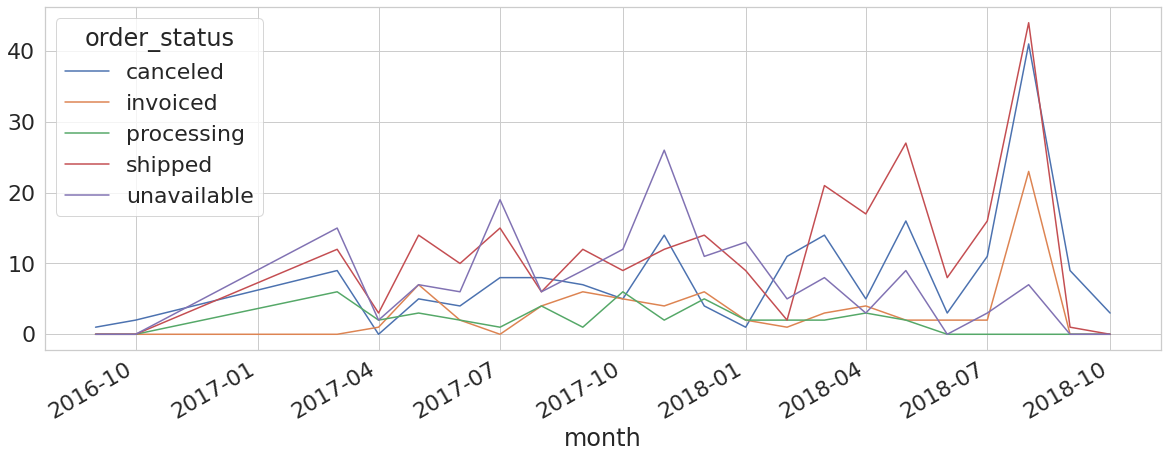

In [23]:
month_not_delivered.plot()

In [24]:
month_not_delivered.mean().round(0)

order_status
canceled        8.0
invoiced        3.0
processing      2.0
shipped        11.0
unavailable     7.0
dtype: float64

Summary по причинам:<br>
1) основная причина - медленная доставка, в среднем 11 заказов не успевают доставить вовремя;<br>
2) 8 заказов в месяц в среднем отменяется;<br>
3) 7 заказов недоступны;<br>
4) для 3 выставлен счёт, но не проведена оплата<br>
5) в среднем 3 заказа в месяц застревают на складе в процессе сборки<br>

P.S. Сумма равна 31, а не 32 из-за округления

## 3. По каждому товару определить, в какой день недели товар чаще всего покупается.

Поскольку данные о товаре и о дате находятся в разных датафреймах - смёрджим их

In [25]:

orders_with_items = orders.merge(items, how = 'inner', on = 'order_id')

Отберём только нужные столбцы

In [26]:

df_item_date = orders_with_items[['product_id', 'order_purchase_timestamp']]

Переведём дату заказа в значение недели

In [27]:

df_item_date['day_of_week'] = df_item_date.order_purchase_timestamp.dt.day_name()

In [28]:
df_item_date

,product_id,order_purchase_timestamp,day_of_week
0,87285b34884572647811a353c7ac498a,2017-10-02 10:56:33,Monday
1,595fac2a385ac33a80bd5114aec74eb8,2018-07-24 20:41:37,Tuesday
2,aa4383b373c6aca5d8797843e5594415,2018-08-08 08:38:49,Wednesday
3,d0b61bfb1de832b15ba9d266ca96e5b0,2017-11-18 19:28:06,Saturday
4,65266b2da20d04dbe00c5c2d3bb7859e,2018-02-13 21:18:39,Tuesday
...,...,...,...
112645,f1d4ce8c6dd66c47bbaa8c6781c2a923,2018-02-06 12:58:58,Tuesday
112646,b80910977a37536adeddd63663f916ad,2017-08-27 14:46:43,Sunday
112647,d1c427060a0f73f6b889a5c7c61f2ac4,2018-01-08 21:28:27,Monday
112648,d1c427060a0f73f6b889a5c7c61f2ac4,2018-01-08 21:28:27,Monday


Посчитаем, какое количество видов товаров у нас вообще есть, это число понадобится далее для проверки

In [29]:
df_item_date.groupby(['product_id', 'day_of_week']).agg({'order_purchase_timestamp':'count'}).reset_index().product_id.nunique()

32951

In [30]:
final_item_date_df = df_item_date.groupby(['product_id', 'day_of_week']).agg({'order_purchase_timestamp':'count'}) \
.groupby('product_id').idxmax().reset_index()

In [31]:
final_item_date_df.head()

,product_id,order_purchase_timestamp
0,00066f42aeeb9f3007548bb9d3f33c38,"(00066f42aeeb9f3007548bb9d3f33c38, Sunday)"
1,00088930e925c41fd95ebfe695fd2655,"(00088930e925c41fd95ebfe695fd2655, Tuesday)"
2,0009406fd7479715e4bef61dd91f2462,"(0009406fd7479715e4bef61dd91f2462, Thursday)"
3,000b8f95fcb9e0096488278317764d19,"(000b8f95fcb9e0096488278317764d19, Friday)"
4,000d9be29b5207b54e86aa1b1ac54872,"(000d9be29b5207b54e86aa1b1ac54872, Tuesday)"


In [32]:
final_item_date_df['max_sell_buy_of_week'] = final_item_date_df.order_purchase_timestamp.apply( \
lambda x: list(x)[-1])

In [33]:
final_item_date_df = final_item_date_df.drop (columns = 'order_purchase_timestamp')

In [34]:
final_item_date_df

,product_id,max_sell_buy_of_week
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday
1,00088930e925c41fd95ebfe695fd2655,Tuesday
2,0009406fd7479715e4bef61dd91f2462,Thursday
3,000b8f95fcb9e0096488278317764d19,Friday
4,000d9be29b5207b54e86aa1b1ac54872,Tuesday
...,...,...
32946,fff6177642830a9a94a0f2cba5e476d1,Saturday
32947,fff81cc3158d2725c0655ab9ba0f712c,Monday
32948,fff9553ac224cec9d15d49f5a263411f,Friday
32949,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday


Мы сохранили исходное количество товаров 32951, при этом напротив товара в датафрейме final_item_date_df теперь день недели, в который его чаще всего покупают, теперь через query можно выбрать любой товар и узнать этот день

## 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? 
Не стоит забывать, что внутри месяца может быть не целое количество недель. 
Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

Как можно вспомнить из первого задания, за совершённую покупку мы считаем только те заказы, которые были доставлены, то есть обязательства обеих сторон были выполнены - продавец получил деньги, а покупатель товар. Однако, датой совершения покупки мы будем считать дату создания заказа, потому что именно в этот момент пользователь принимает решение о совершении покупки. 

Отмечу, что данный метод подходит только для анализа данных постфактум, когда мы точно знаем, что покупка в итоге состоялась, то есть была доставлена. Если бы анализ проводился в форме мониторинга, а данные бы обновлялись еженедельно на интерактивном дашборде, то следовало бы использовать дату доставки, поскольку дата оформления заказа не была бы точным показателем - ведь посчитанная сегодня таким образом покупка уже завтра может быть отменена как пользователем, так и со стороны поставщиков из-за отсутствия товара.

In [35]:
df_people_date = orders_with_customers.query('order_status == "delivered"')[['customer_unique_id', 'order_purchase_timestamp']]

Отбираем месяцы

In [36]:
df_people_date['month'] = df_people_date['order_purchase_timestamp'].dt.to_period('M')

Узнаём, сколько в месяце недель

In [37]:

df_people_date['weeks_in_month'] =  df_people_date['month'].dt.daysinmonth/7

In [38]:
df_people_date.head()

,customer_unique_id,order_purchase_timestamp,month,weeks_in_month
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,2017-10,4.428571
1,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,2018-07,4.428571
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49,2018-08,4.428571
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06,2017-11,4.285714
4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39,2018-02,4.000000


Подсчитываем количество покупок по каждому пользователю в каждом месяце

In [39]:
df_mean_by_week = df_people_date.groupby(['customer_unique_id','month','weeks_in_month']) \
.agg({'order_purchase_timestamp':'count'}).reset_index()

В каждом месяце делим количество покупок на количество недель - получаем среднее за неделю в данном месяце

In [40]:
df_mean_by_week ['week_mean_by_month'] = df_mean_by_week.order_purchase_timestamp/df_mean_by_week.weeks_in_month

In [41]:
#для удобства отбираем только нужные колонки, без промежуточных, которые использовались в расчётах
df_mean_by_week [['customer_unique_id','month', 'week_mean_by_month']] \
# дальше можно отбирать значения по конкретному пользователю
#.query('customer_unique_id == "Здесь указываем интересующий id"')
# можно отбирать по месяцу 
#.query('month == "указываем интересующий месяц в формате YYYY-MM"')

,customer_unique_id,month,week_mean_by_month
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,0.225806
2,0000f46a3911fa3c0805444483337064,2017-03,0.225806
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,0.225806
4,0004aac84e0df4da2b147fca70cf8255,2017-11,0.233333
...,...,...,...
95189,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06,0.233333
95190,fffea47cd6d3cc0a88bd621562a9d061,2017-12,0.225806
95191,ffff371b4d645b6ecea244b27531430a,2017-02,0.250000
95192,ffff5962728ec6157033ef9805bacc48,2018-05,0.225806


## 5. Когортный анализ пользователей. 
В период с января по декабрь выявляем когорту с самым высоким retention на 3й месяц.

In [42]:
for_cohorts = orders_with_customers.query('order_status == "delivered"')[['order_purchase_timestamp', 'customer_unique_id']]

In [43]:
for_cohorts['order_period'] = for_cohorts.order_purchase_timestamp.apply(lambda x: x.strftime('%Y-%m'))

Данные за целый год у нас есть только в 2017, поэтому для анализа будем использовать только те наблюдения, где первая покупка была совершена в 2017.

In [44]:
for_cohorts = for_cohorts.query('order_period > "2016-12"')

In [45]:
for_cohorts.set_index('customer_unique_id', inplace=True)
for_cohorts['join_month'] = for_cohorts.groupby(level=0)['order_purchase_timestamp'].min().apply(lambda x: x.strftime('%Y-%m'))
for_cohorts.reset_index(inplace=True)
for_cohorts.head(3)

,customer_unique_id,order_purchase_timestamp,order_period,join_month
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,2017-10,2017-09
1,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,2018-07,2018-07
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49,2018-08,2018-08


In [46]:
grouped = for_cohorts.groupby(['join_month','order_period'])
cohorts = grouped.agg({'customer_unique_id': pd.Series.nunique,})
cohorts.rename(columns={'customer_unique_id': 'total_users'}, inplace=True)
cohorts.head()

total_users
join_month order_period             
2017-01    2017-01               718
           2017-02                 2
           2017-03                 2
           2017-04                 1
           2017-05                 3

In [47]:
def cohort_period(df):
    df['cohort_period'] = np.arange(len(df)) + 0
    return df
cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts.head()

total_users  cohort_period
join_month order_period                            
2017-01    2017-01               718              0
           2017-02                 2              1
           2017-03                 2              2
           2017-04                 1              3
           2017-05                 3              4

Представим количество пользователей в каждой когорте по месяцам в таблице

In [48]:
cohorts.reset_index(inplace=True)
cohorts.set_index(['join_month','cohort_period'], inplace=True)
cohorts = cohorts['total_users'].unstack(1).head(12).reset_index()
cohorts.set_index(['join_month'], inplace=True)
cohorts

cohort_period,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
join_month,,,,,,,,,,,,,,,,,,
2017-01,718.0,2.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,3.0,1.0,5.0,3.0,1.0,1.0,2.0,3.0,1.0
2017-02,1628.0,3.0,5.0,2.0,7.0,2.0,4.0,3.0,2.0,3.0,2.0,5.0,2.0,3.0,2.0,1.0,1.0,3.0
2017-03,2503.0,11.0,9.0,10.0,9.0,4.0,4.0,8.0,8.0,2.0,9.0,3.0,5.0,3.0,4.0,6.0,2.0,3.0
2017-04,2257.0,14.0,5.0,4.0,6.0,6.0,8.0,7.0,7.0,4.0,6.0,2.0,1.0,1.0,2.0,2.0,3.0,NaN
2017-05,3451.0,16.0,16.0,10.0,10.0,11.0,14.0,5.0,9.0,9.0,9.0,12.0,8.0,1.0,6.0,7.0,NaN,NaN
2017-06,3037.0,15.0,12.0,13.0,9.0,12.0,11.0,7.0,4.0,6.0,9.0,11.0,5.0,5.0,7.0,NaN,NaN,NaN
2017-07,3753.0,20.0,13.0,9.0,11.0,8.0,12.0,4.0,7.0,10.0,8.0,11.0,5.0,9.0,NaN,NaN,NaN,NaN
2017-08,4057.0,28.0,14.0,11.0,14.0,21.0,12.0,11.0,6.0,6.0,10.0,8.0,5.0,NaN,NaN,NaN,NaN,NaN
2017-09,4005.0,28.0,22.0,11.0,18.0,9.0,9.0,10.0,11.0,8.0,10.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN


Построим retention матрицу, разделив для каждой когорты абсолютные значения по периодам на изначальный размер когорты

In [49]:
cohort_size = cohorts.iloc[:,0]
retention_matrix = round(cohorts.divide(cohort_size, axis = 0)*100,2)

In [50]:
retention_matrix = retention_matrix.reset_index()
retention_matrix = retention_matrix.drop(columns=retention_matrix.iloc[: , 14:19])
retention_matrix.set_index(['join_month'], inplace=True)

In [51]:
retention_matrix

cohort_period,0,1,2,3,4,5,6,7,8,9,10,11,12
join_month,,,,,,,,,,,,,
2017-01,100.0,0.28,0.28,0.14,0.42,0.14,0.42,0.14,0.14,0.42,0.14,0.70,0.42
2017-02,100.0,0.18,0.31,0.12,0.43,0.12,0.25,0.18,0.12,0.18,0.12,0.31,0.12
2017-03,100.0,0.44,0.36,0.40,0.36,0.16,0.16,0.32,0.32,0.08,0.36,0.12,0.20
2017-04,100.0,0.62,0.22,0.18,0.27,0.27,0.35,0.31,0.31,0.18,0.27,0.09,0.04
2017-05,100.0,0.46,0.46,0.29,0.29,0.32,0.41,0.14,0.26,0.26,0.26,0.35,0.23
2017-06,100.0,0.49,0.40,0.43,0.30,0.40,0.36,0.23,0.13,0.20,0.30,0.36,0.16
2017-07,100.0,0.53,0.35,0.24,0.29,0.21,0.32,0.11,0.19,0.27,0.21,0.29,0.13
2017-08,100.0,0.69,0.35,0.27,0.35,0.52,0.30,0.27,0.15,0.15,0.25,0.20,0.12
2017-09,100.0,0.70,0.55,0.27,0.45,0.22,0.22,0.25,0.27,0.20,0.25,0.07,NaN


Таким образом, наибольший Retention на третий месяц в рассматриваемом периоде показывает когорта пользователей, совершивших первую покупку в июне 2017 года. Данный показатель равен 0.43%, что можно считать крайне маленьким показателем, который обусловлен прежде всего базовой проблемой выявленной ранее - 97% пользователей совершает лишь одну покупку и не возвращается к сервису.

## 6. RFM-сегментация пользователей 

Метрики: <br>

    R - время от последней покупки пользователя до текущей даты<br>
    F - суммарное количество покупок у пользователя за всё время<br>
    M - сумма покупок за всё время. <br>

In [52]:
full_df = orders_with_customers.merge (items, how = 'inner', on = 'order_id')

In [53]:
full_df

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP,1,f1d4ce8c6dd66c47bbaa8c6781c2a923,1f9ab4708f3056ede07124aad39a2554,2018-02-12 13:10:37,174.90,20.10
112646,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA,1,b80910977a37536adeddd63663f916ad,d50d79cb34e38265a8649c383dcffd48,2017-09-05 15:04:16,205.99,65.02
112647,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ,1,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59
112648,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ,2,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59


In [54]:
full_df = full_df.query('order_status =="delivered"')
#для rfm анализа необходимы данные по совершившимся покупкам

Поскольку данные старые, нет смысла использовать текущую дату для подсчёта recency, поэтому используем последнюю имеющуюся дату + 1 день. За дату покупки также будем принимать дату создания заказа.

In [55]:
last_date = full_df['order_purchase_timestamp'].max() + timedelta(days=1)

In [56]:
to_rfm = full_df.groupby('customer_unique_id').agg({'order_purchase_timestamp': lambda x: (last_date - x.max()).days, 
                                                   'order_id' :'nunique', 
                                                   'price': lambda x: x.sum()})

In [57]:
to_rfm.head()

,order_purchase_timestamp,order_id,price
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90
0000f46a3911fa3c0805444483337064,537,1,69.00
0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99
0004aac84e0df4da2b147fca70cf8255,288,1,180.00


In [58]:
to_rfm.rename(columns={'order_purchase_timestamp': 'recency', 
                       'order_id': 'frequency', 
                       'price': 'monetary'}, inplace=True)

In [59]:
to_rfm

,recency,frequency,monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90
0000f46a3911fa3c0805444483337064,537,1,69.00
0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99
0004aac84e0df4da2b147fca70cf8255,288,1,180.00
...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,447,1,1570.00
fffea47cd6d3cc0a88bd621562a9d061,262,1,64.89
ffff371b4d645b6ecea244b27531430a,568,1,89.90


Изучим величины, чтобы посмотреть на сколько сегментов и каким образом делить наши данные

In [60]:
to_rfm.describe()

,recency,frequency,monetary
count,93358.000000,93358.000000,93358.000000
mean,237.941773,1.033420,141.621480
std,152.591453,0.209097,215.694014
min,1.000000,1.000000,0.850000
25%,114.000000,1.000000,47.650000
50%,219.000000,1.000000,89.730000
75%,346.000000,1.000000,154.737500
max,714.000000,15.000000,13440.000000


In [61]:
to_rfm.monetary.quantile(q=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99])

0.10      25.980
0.20      39.900
0.30      52.990
0.40      69.900
0.50      89.730
0.60     109.900
0.70     139.000
0.80     179.900
0.90     279.990
0.95     419.809
0.99    1004.990
Name: monetary, dtype: float64

In [62]:
to_rfm.recency.quantile(q=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99])

0.10     42.0
0.20     92.0
0.30    134.0
0.40    177.0
0.50    219.0
0.60    268.0
0.70    312.0
0.80    382.0
0.90    466.0
0.95    520.0
0.99    575.0
Name: recency, dtype: float64

In [63]:
to_rfm.frequency.quantile(q=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99])

0.10    1.0
0.20    1.0
0.30    1.0
0.40    1.0
0.50    1.0
0.60    1.0
0.70    1.0
0.80    1.0
0.90    1.0
0.95    1.0
0.99    2.0
Name: frequency, dtype: float64

In [64]:
to_rfm.reset_index().groupby('frequency').agg({'customer_unique_id':'count'})

,customer_unique_id
frequency,
1,90557
2,2573
3,181
4,28
5,9
6,5
7,3
9,1
15,1


Для monetary и recency можно использовать метод квантилей и по каждой из величин сформировать по 5 сегментов.
Для frequency такой подход не сработает в силу особенностей данных (97% пользователей сделали только одну покупку), поэтому сегменты будем задавать вручную, опираясь на таблицу выше с количеством пользователей на разное количество покупок.<br>

In [65]:
quintiles = to_rfm[['recency', 'monetary']].quantile([0.2, 0.4, 0.6, 0.8]).to_dict()
quintiles

{'recency': {0.2: 92.0, 0.4: 177.0, 0.6: 268.0, 0.8: 382.0},
 'monetary': {0.2: 39.9, 0.4: 69.9, 0.6: 109.9, 0.8: 179.9}}

Необходимо, чтобы метрика была логичной - чем выше ранг, тем лучше.
Для monetary и frequency это по возрастанию - чем больше доход и количество покупок, тем лучше.
Для recency наоборот, чем больше промежуток между покупкой и контрольной датой, тем хуже, поэтому мы будем присваивать ранги по убыванию -  чем меньше квартиль, тем выше ранг.

Описание границ метрик

Recency:<br>
1 - больше 382 дней с момента последней покупки<br>
2 - от 267 до 382 дней с момента последней покупки<br>
3 - от 177 до 267 дней с момента последней покупки<br>
4 - от 92 до 177 дней с момента последней покупки<br>
5 - меньше 92 дней с момента последней покупки<br>

Frequency:<br>
1 - 1 покупка <br>
2 - от 2 до 4 покупок<br>
3 - от 5 до 7 покупок<br>
4 - от 8 до 12 покупок<br>
5 - 13 и более покупок<br>

Monetary<br>
1 - сумма покупок пользователя меньше 39.9 долларов<br>
2 - сумма покупок пользователя от 39.9 долларов  до 69.9<br>
3 - сумма покупок пользователя от 69.9 долларов до 109.9<br>
4 - сумма покупок пользователя от 109.9 долларов до 179.9<br>
5 - сумма покупок пользователя 179.9 долларов и выше<br>

In [66]:
def r_score(x):
    if x <= quintiles['recency'][.2]:
        return 5
    elif x <= quintiles['recency'][.4]:
        return 4
    elif x <= quintiles['recency'][.6]:
        return 3
    elif x <= quintiles['recency'][.8]:
        return 2
    else:
        return 1

def m_score(x):
    if x <= quintiles['monetary'][.2]:
        return 1
    elif x <= quintiles['monetary'][.4]:
        return 2
    elif x <= quintiles['monetary'][.6]:
        return 3
    elif x <= quintiles['monetary'][.8]:
        return 4
    else:
        return 5

def f_score(x):
    if x == 1:
        return 1
    elif x > 1 and x < 5:
        return 2
    elif x > 4 and x < 8:
        return 3
    elif x > 7 and x < 13:
        return 4
    else:
        return 5

In [67]:
to_rfm['R'] = to_rfm['recency'].apply(lambda x: r_score(x))
to_rfm['F'] = to_rfm['frequency'].apply(lambda x: f_score(x))
to_rfm['M'] = to_rfm['monetary'].apply(lambda x: m_score(x))
to_rfm['RFM_Score'] = to_rfm['R'].map(str) + to_rfm['F'].map(str) + to_rfm['M'].map(str)
to_rfm.head()

,recency,frequency,monetary,R,F,M,RFM_Score
customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,4,1,4,414
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,4,1,1,411
0000f46a3911fa3c0805444483337064,537,1,69.00,1,1,2,112
0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,2,1,1,211
0004aac84e0df4da2b147fca70cf8255,288,1,180.00,2,1,5,215


Всего мы имеем 125 сегментов, снизим их количество, используя показатели Recency и Frequency без учёта Monetary.

Описание сегментов:
1. Hibernating - последняя покупка произошла более чем 267 дней назад, соверешено не более 4 покупок
2. At risk - последняя покупка произошла более чем 267 дней назад, от 5 до 12 покупок
3. Сan\'t loose - последняя покупка произошла более чем 268 дней назад, совершено 13 и более покупок
4. About to sleep - от 177 до 267 дней с момента последней покупки, соверешено не более 4 покупок
5. Need attention - от 177 до 267 дней с момента последней покупки,  от 5 до 7 покупок
6. Loyal customers - от 92 до 267 дней с момента последней покупки, совершено более 8 покупок
7. Promising - от 92 до 177 дней с момента последней покупки, 1 покупка
8. New customers - меньше 92 дней с момента последней покупки, 1 покупка
9. Potential loyalists - меньше 177 дней с момента последней покупки, от 2 до 7 покупок
10.Champions - меньше 92 дней с момента последней покупки, совершено более 8 покупок

In [68]:
segt_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at risk',
    r'[1-2]5': 'can\'t loose',
    r'3[1-2]': 'about to sleep',
    r'33': 'need attention',
    r'[3-4][4-5]': 'loyal customers',
    r'41': 'promising',
    r'51': 'new customers',
    r'[4-5][2-3]': 'potential loyalists',
    r'5[4-5]': 'champions'
}

to_rfm['Segment'] = to_rfm['R'].map(str) + to_rfm['F'].map(str)
to_rfm['Segment'] = to_rfm['Segment'].replace(segt_map, regex=True)
to_rfm.head()

,recency,frequency,monetary,R,F,M,RFM_Score,Segment
customer_unique_id,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,4,1,4,414,promising
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,4,1,1,411,promising
0000f46a3911fa3c0805444483337064,537,1,69.00,1,1,2,112,hibernating
0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,2,1,1,211,hibernating
0004aac84e0df4da2b147fca70cf8255,288,1,180.00,2,1,5,215,hibernating


Визуализируем количество пользователей в разных сегментах

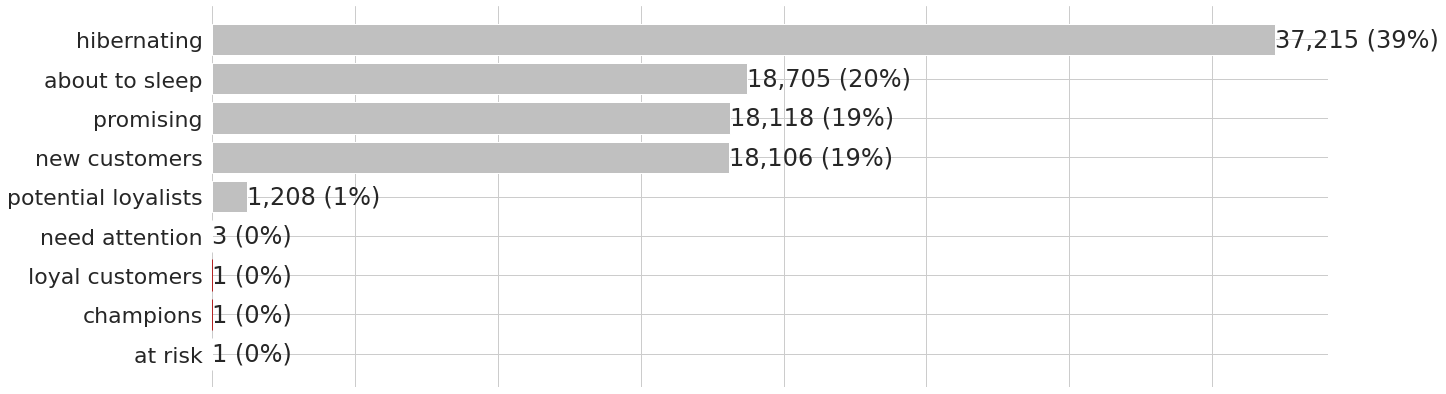

In [69]:
segments_counts = to_rfm['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['champions', 'loyal customers']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()

Взглянем на график средней величины чека для различных сегментов

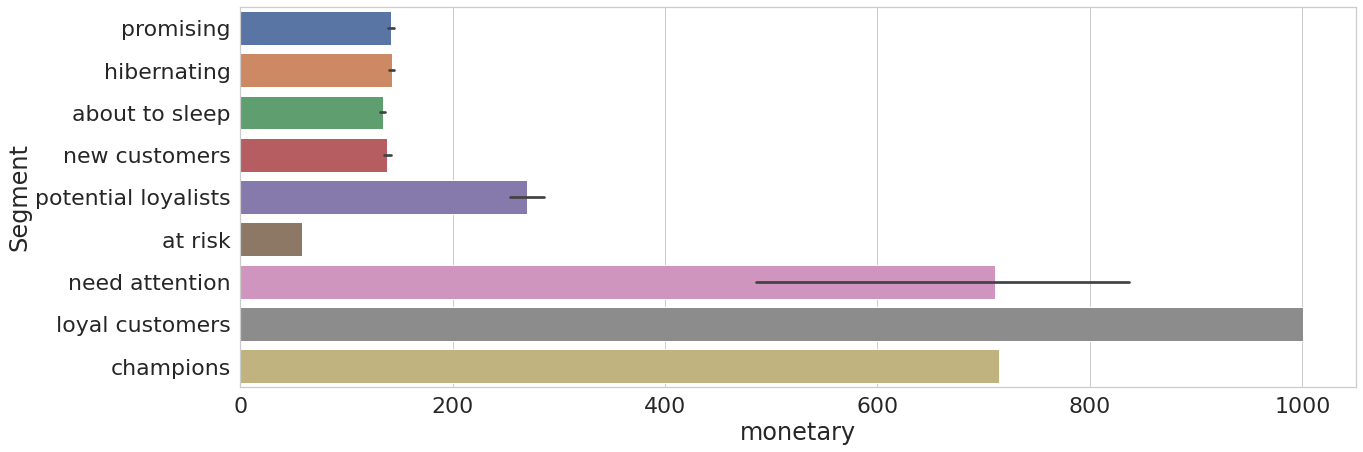

In [70]:
sns.barplot(data=to_rfm, x=to_rfm.monetary, y=to_rfm.Segment)

Необходимо понимать, что наиболее  пользователи из сегментов need attention, loyal customers, champions где размер среднего чека значительно выше - это единичные случаи. Подавляющее большинство пользователей приносит разовую прибыль менее 200 долларов.

Среди всех сегментов, особое внимание следует уделить сегменту potential loyalists. С одной стороны их достаточно много  - 1208 пользователей, а с другой их средний чек значительно выше, чем в других категориях.